# Baseline Synchrony Analysis

In [1]:
import os, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
TABLES_DIRECTORY = "../../Data/giant_new_tables"

# Set up the seaborn style
sns.set_style("whitegrid")

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    # 160,  # weird large synchrony
    172,
    # 141, # not enough time before first seizure
    145,
    # 138,  # weird large synchrony
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196,  # not enough time before first seizure
    # 204,  # not enough time before first seizure
    # 165, # incomplete data
    # 169,  # not enough time after the last seizure
    173,
    150,  # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207,  # not enough time before first seizure
    223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196,  # not enough time before first seizure
    # 204,  # not enough time before first seizure
    177,
    185,
    # 189,  # not enough time before first seizure
    # 205,  # not enough time before first seizure
    166,
    # 170,  # not enough time before first seizure
    # 174,  # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
reinitiation_hup_ids = [142, 145, 166, 173, 174, 177, 180]
reinitiation_start_time_minutes = [17700, 16500, 9950, 12500, 8200, 12050, 9450]
assert len(reinitiation_hup_ids) == len(reinitiation_start_time_minutes)

## Individual Patients

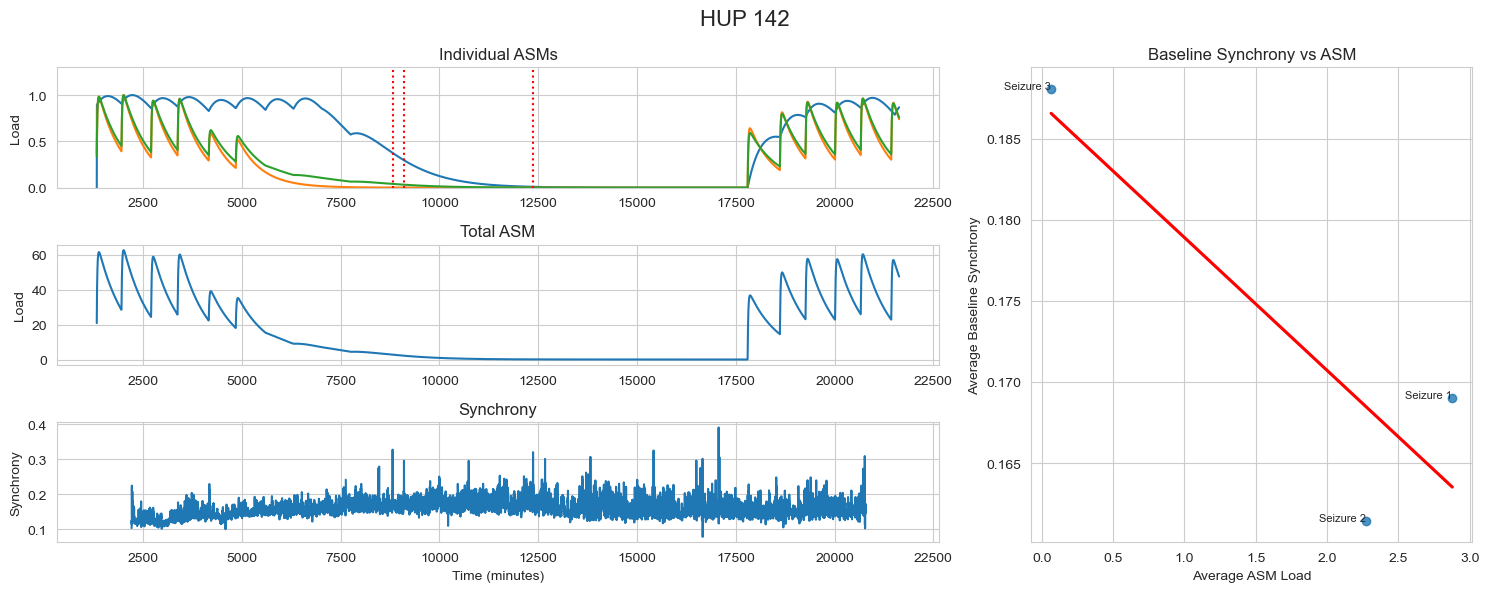

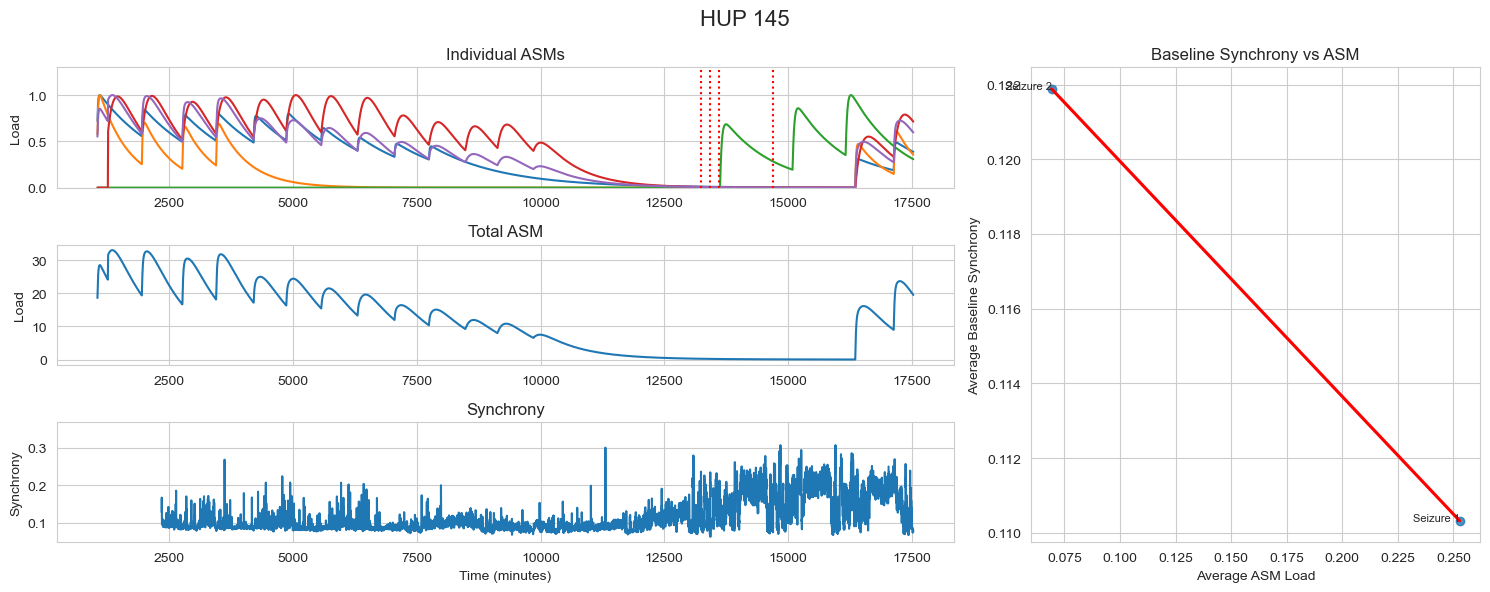

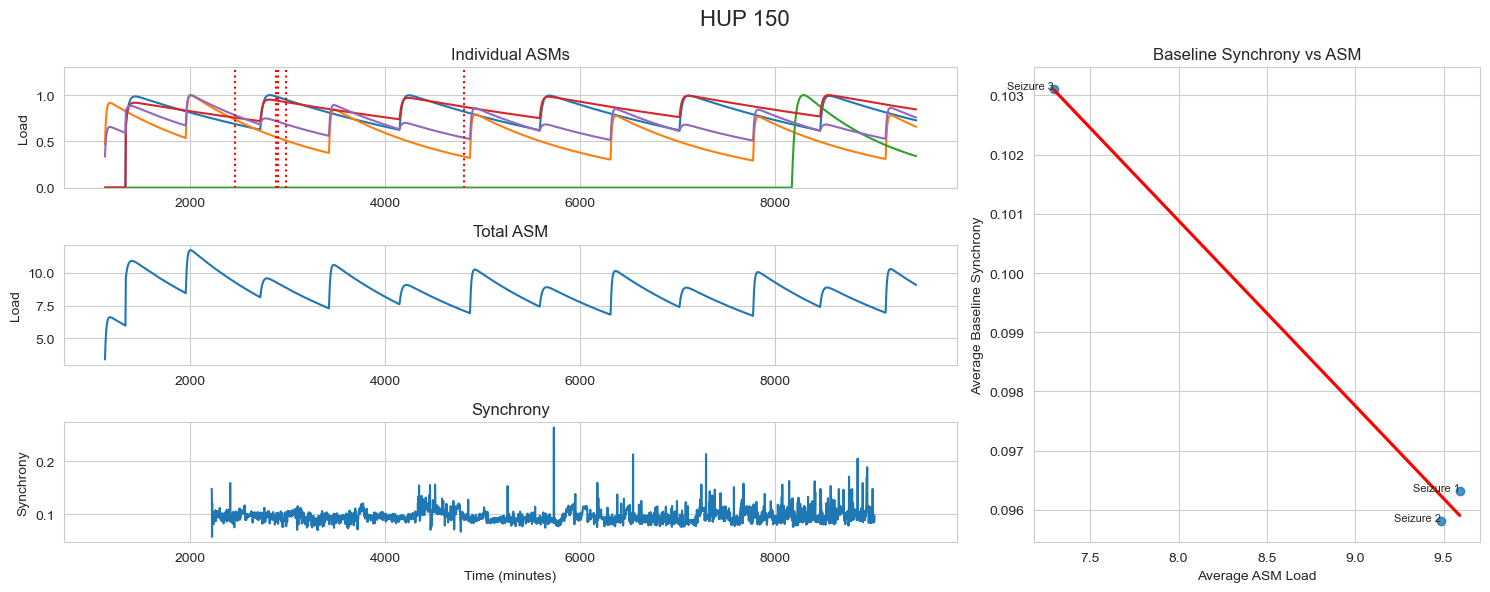

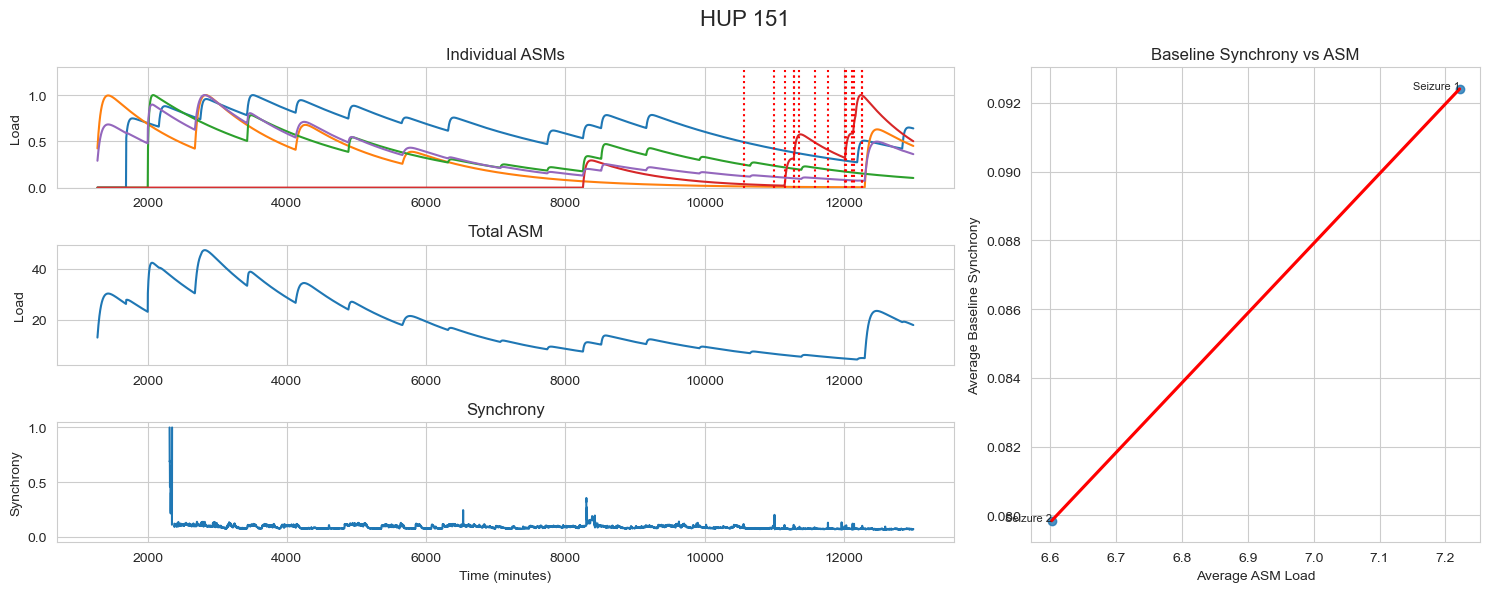

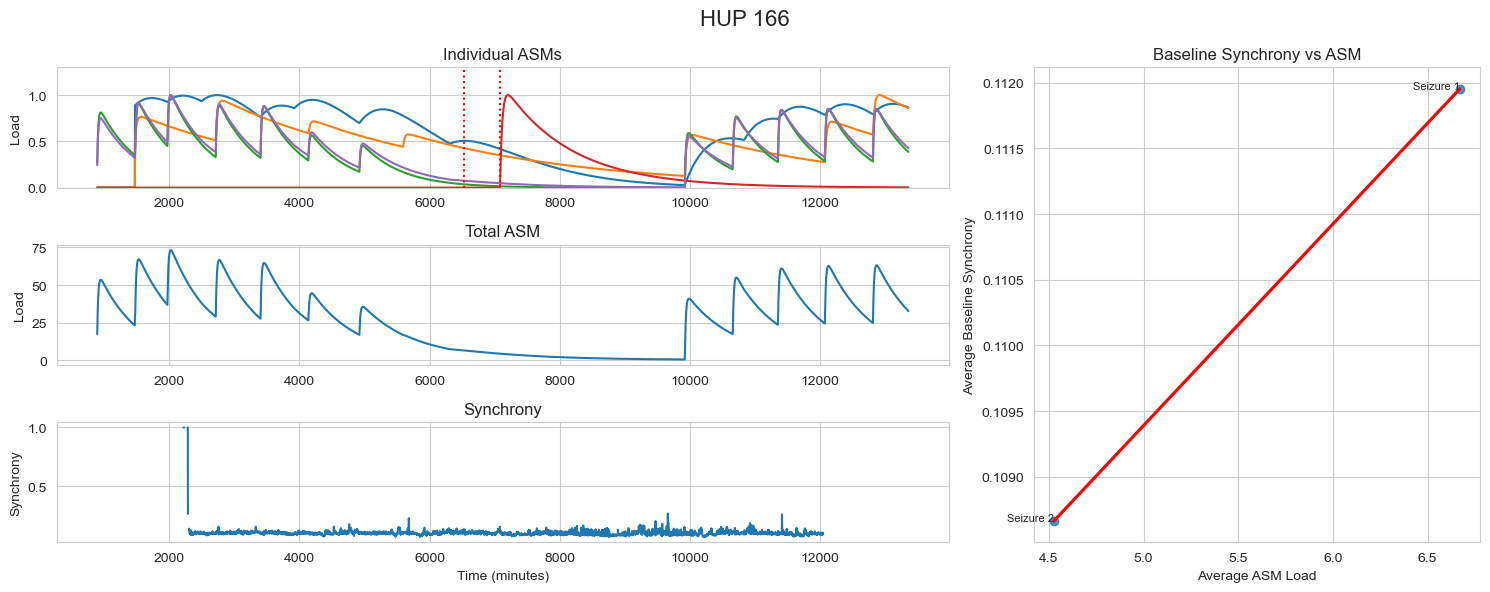

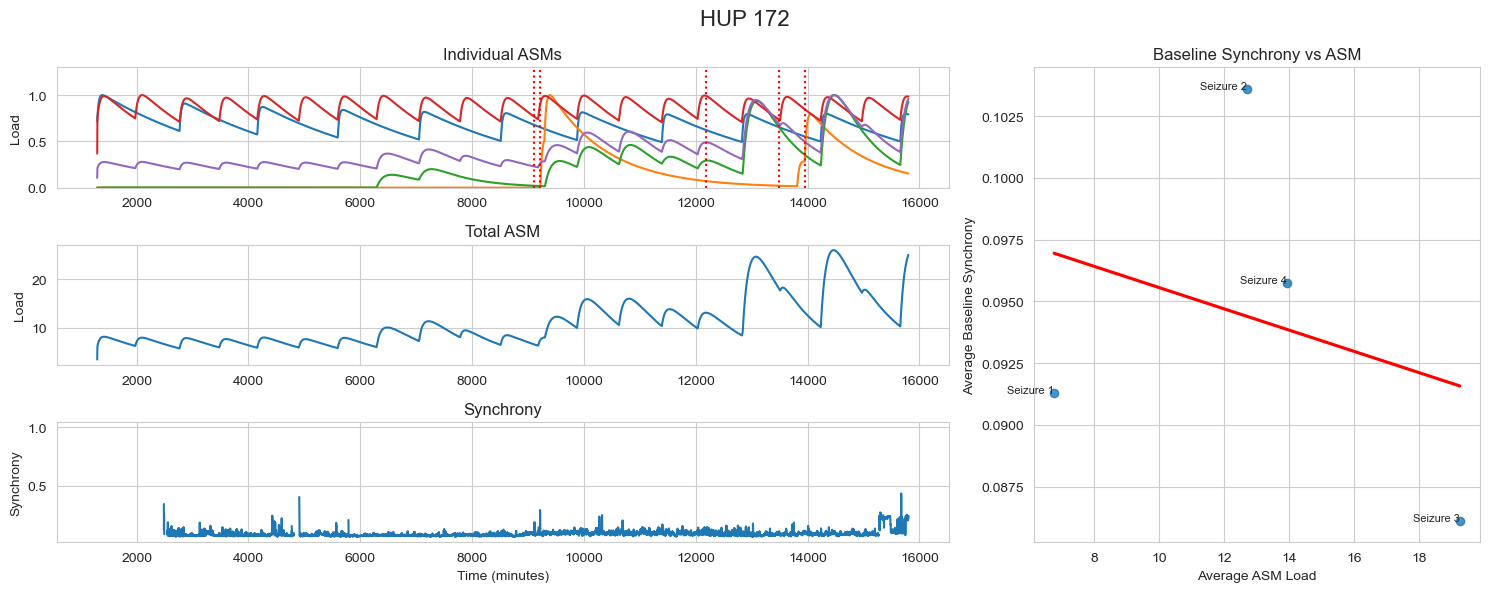

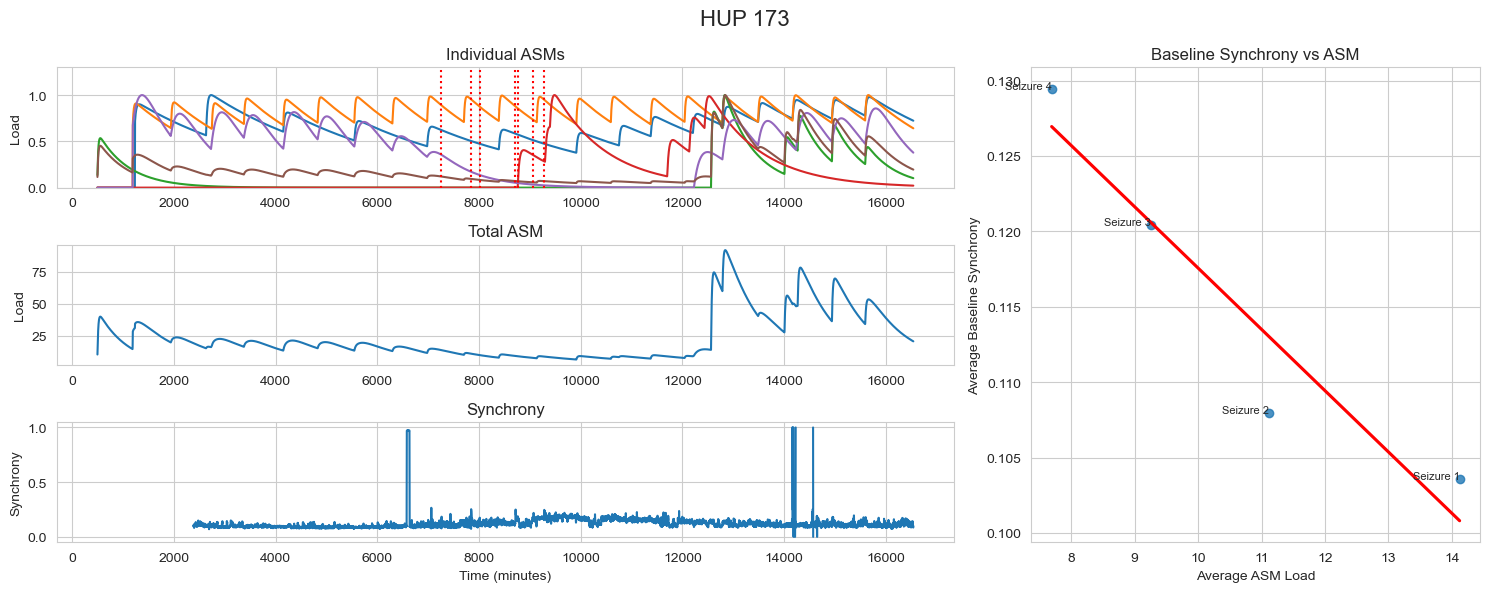

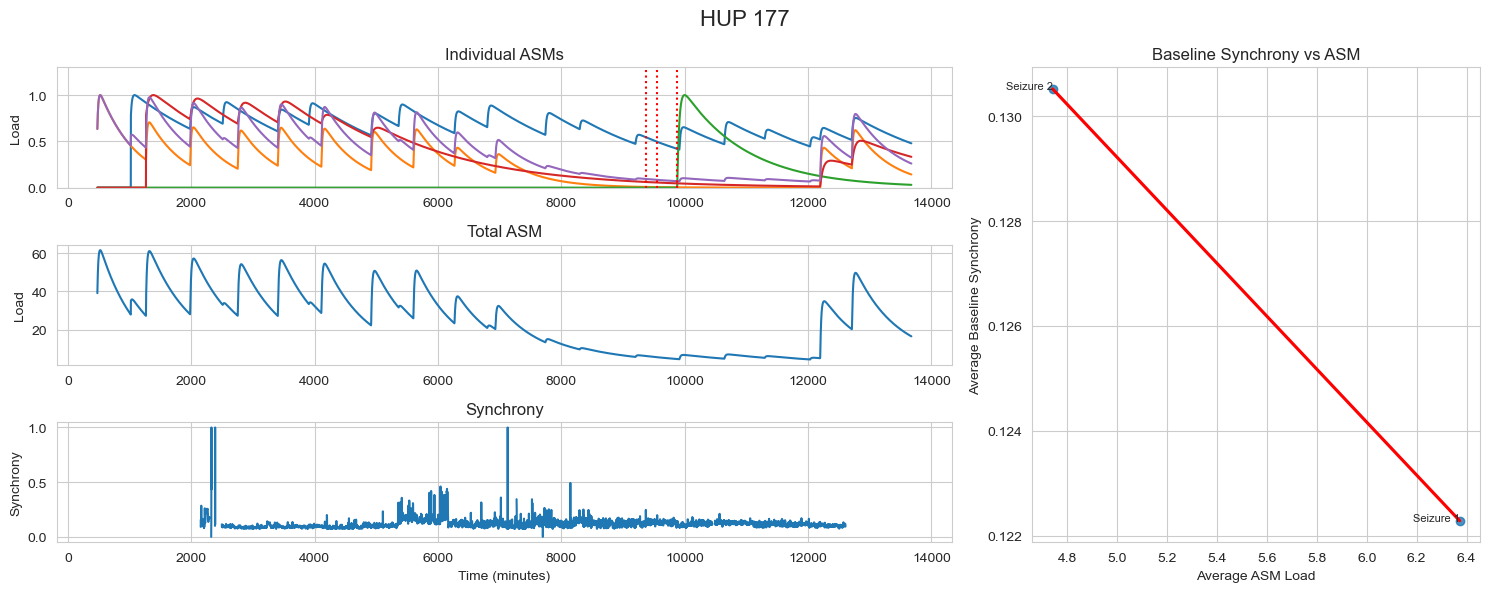

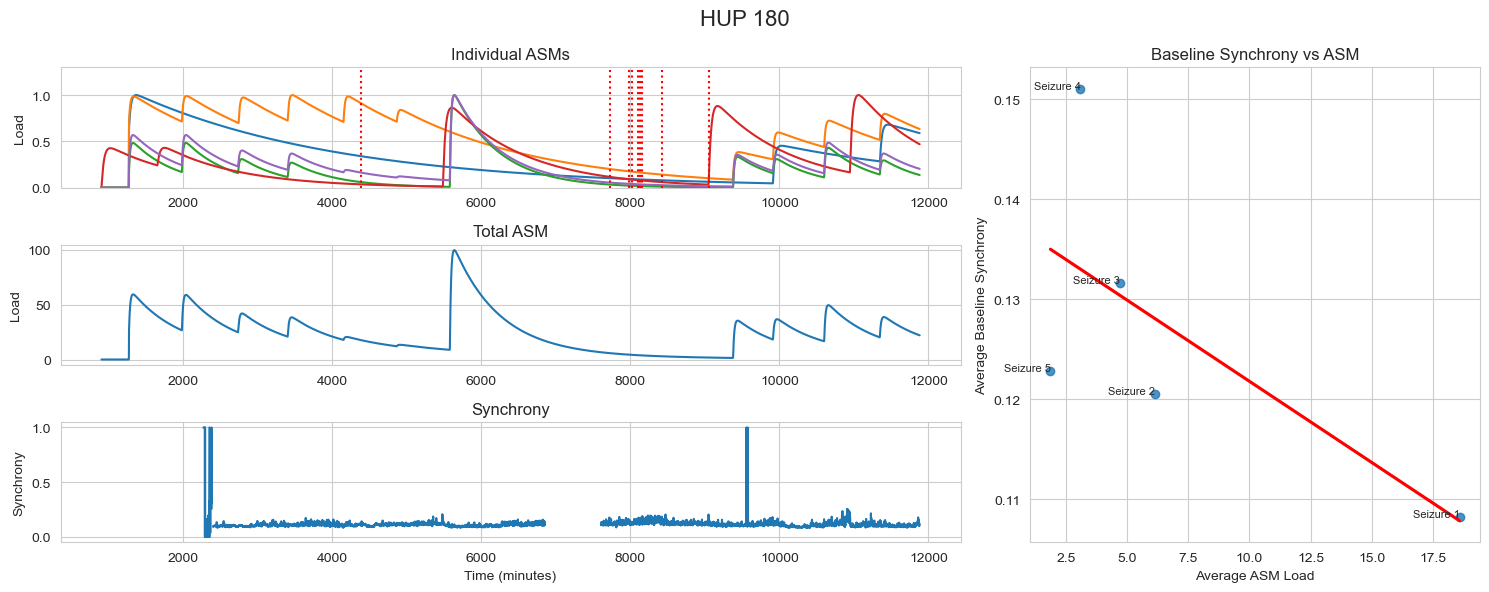

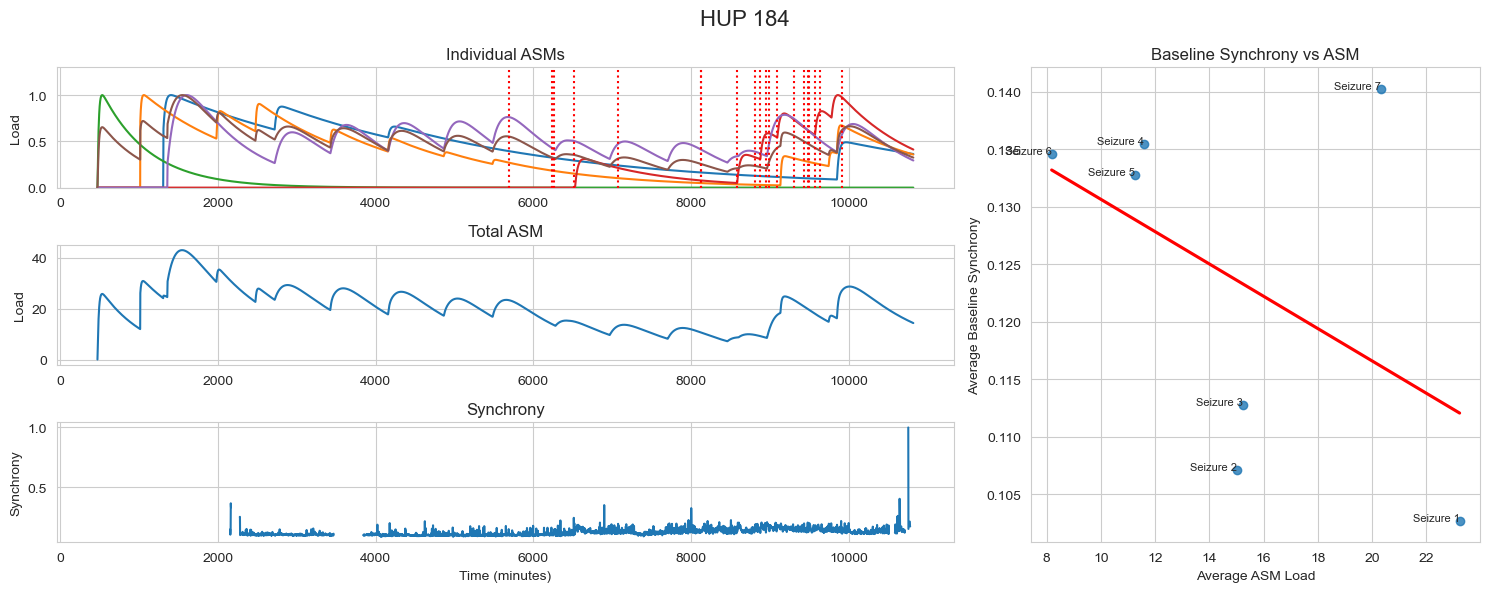

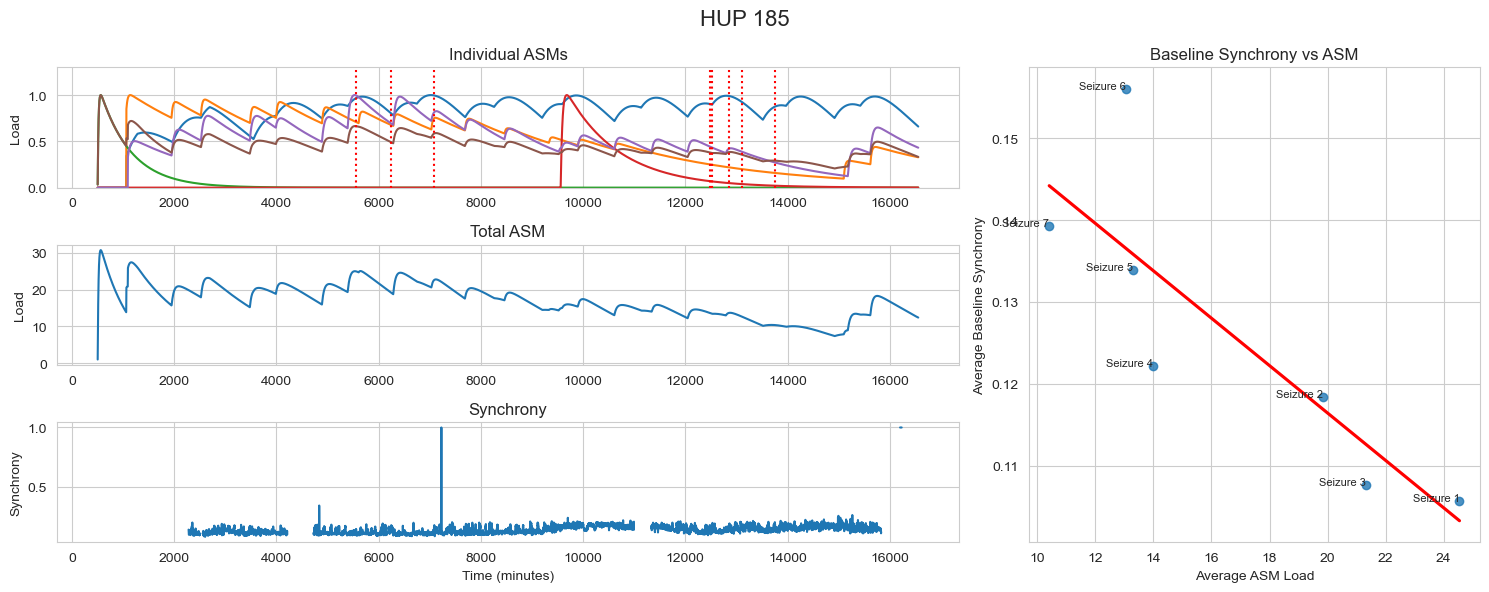

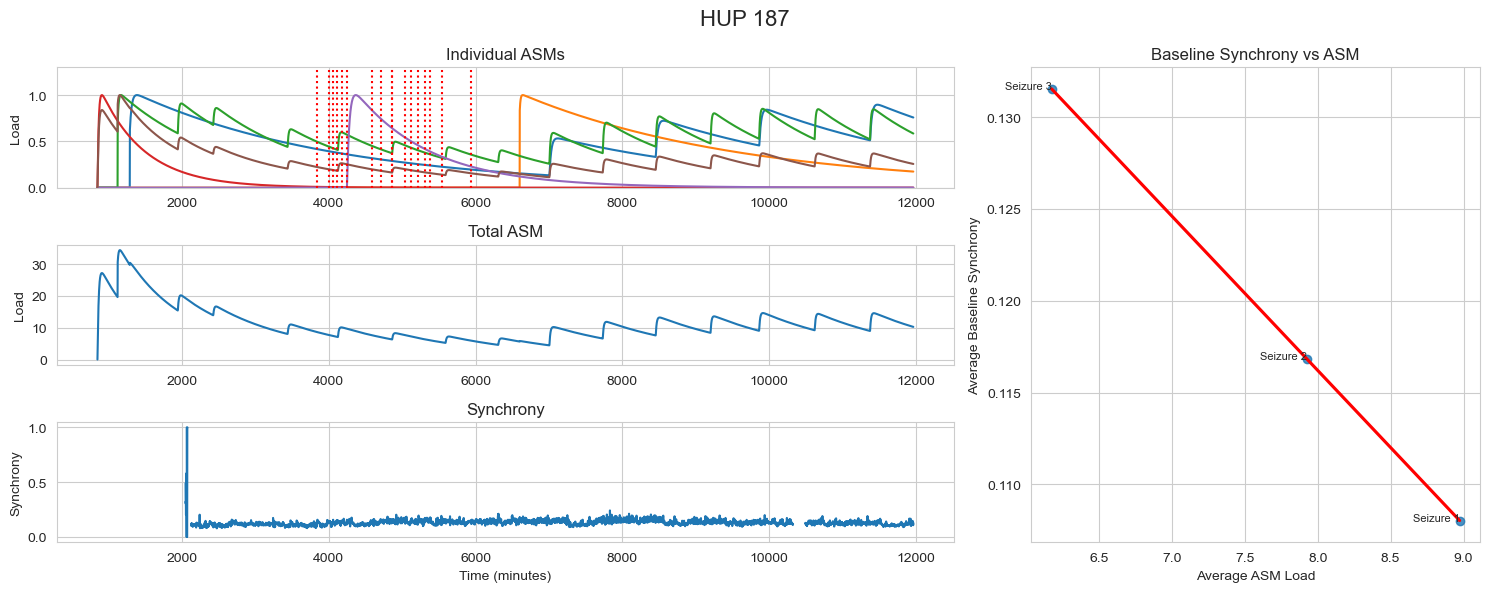

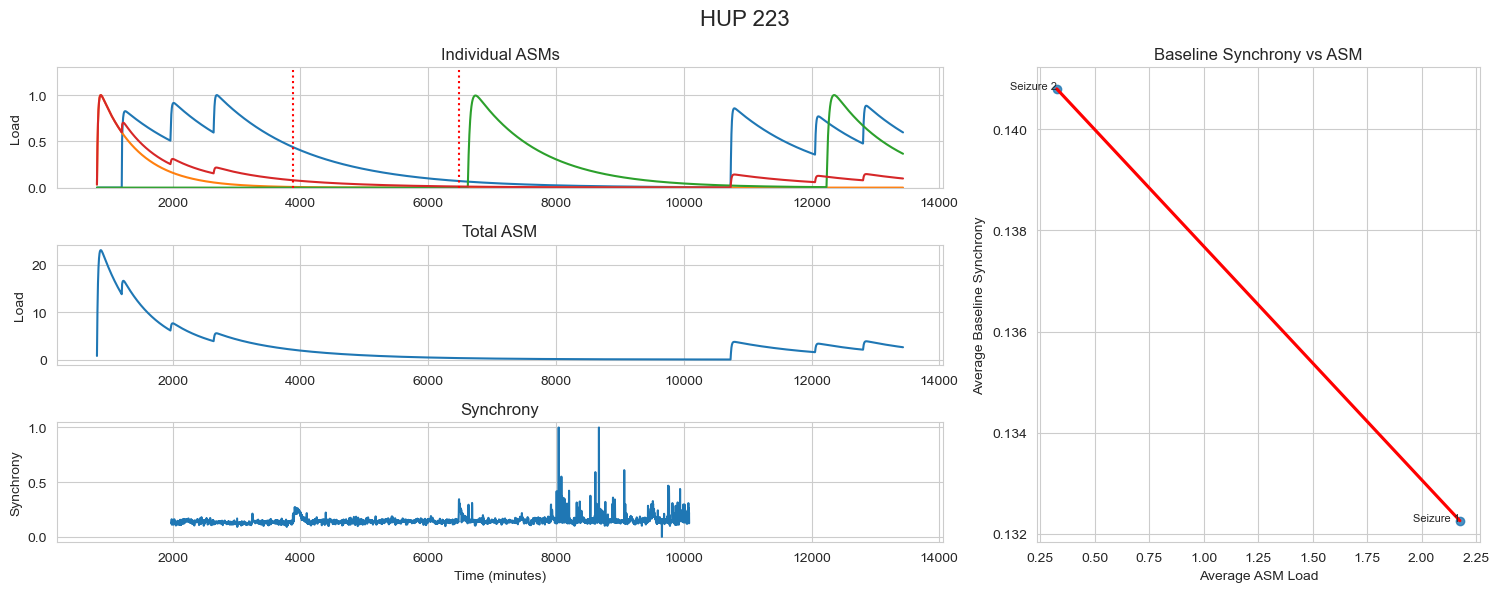

In [5]:
def combined_plot(hourly_patient_features_df, hup_id):
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])

    # Plotting Individual ASMs
    ax0 = plt.subplot(gs[0, 0])

    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_ddd":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax0.plot(hourly_patient_features_df["emu_minute"], normalized_data)

    seizure_minutes = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ]["emu_minute"].values
    for idx in seizure_minutes:
        ax0.axvline(x=idx, color="red", linestyle="dotted")

    ax0.set_ylabel("Load")
    ax0.set_ylim([0, 1.3])
    ax0.set_title("Individual ASMs")

    # Plotting Total ASM
    ax1 = plt.subplot(gs[1, 0], sharex=ax0)
    ax1.plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["med_sum_no_lorazepam_ddd"],
    )
    ax1.set_ylabel("Load")
    ax1.set_title("Total ASM")

    # Plotting synchrony (broadband Band)
    ax2 = plt.subplot(gs[2, 0], sharex=ax0)
    ax2.plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["synchrony_broadband"],
    )
    ax2.set_ylabel("Synchrony")
    ax2.set_title("Synchrony")
    ax2.set_xlabel("Time (minutes)")

    # Scatter plot with regression results
    ax3 = plt.subplot(gs[:, 1])

    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
    ]

    avg_synchronies = []
    avg_med_loads = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_ddd"])

        avg_synchronies.append(avg_synchrony)
        avg_med_loads.append(avg_med_load)

    if avg_med_loads and avg_synchronies:
        sns.regplot(
            x=avg_med_loads,
            y=avg_synchronies,
            scatter=True,
            line_kws={"color": "red"},
            ci=None,
            ax=ax3,
        )

        # Label each dot with its respective seizure number
        for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
            ax3.text(x, y, f"Seizure {i+1}", fontsize=8, ha="right")

        ax3.set_xlabel("Average ASM Load")
        ax3.set_ylabel("Average Baseline Synchrony")
        ax3.set_title(f"Baseline Synchrony vs ASM")
        ax3.grid(True)

    # Subtitle
    fig.suptitle(f"HUP {hup_id}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Loop to call combined_plot
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    combined_plot(hourly_patient_features_df, patient_hup_id)

## Across All Patients

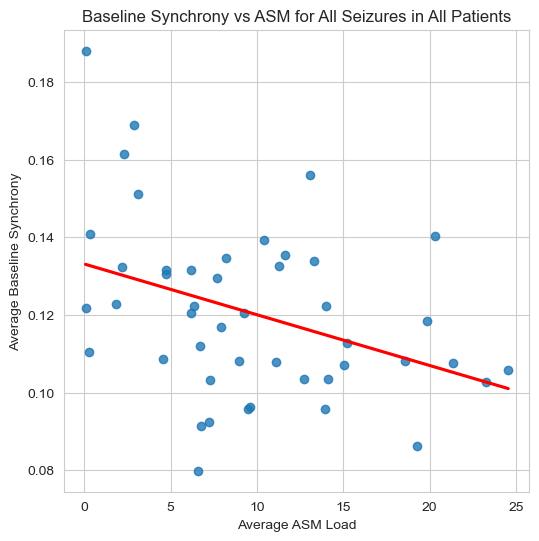

In [6]:
def get_seizure_data(hourly_patient_features_df):
    """
    For a given hourly_patient_features_df, return a list of tuples.
    Each tuple contains avg_med_load and avg_synchrony for each seizure.
    """
    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
    ]

    seizure_data = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_ddd"])

        seizure_data.append((avg_med_load, avg_synchrony))

    return seizure_data


# Accumulate data from all patients
all_seizures_data = []

for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    all_seizures_data.extend(get_seizure_data(hourly_patient_features_df))

# ...

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)

# Convert tuples to lists
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.title("Baseline Synchrony vs ASM for All Seizures in All Patients")
plt.grid(True)
plt.show()

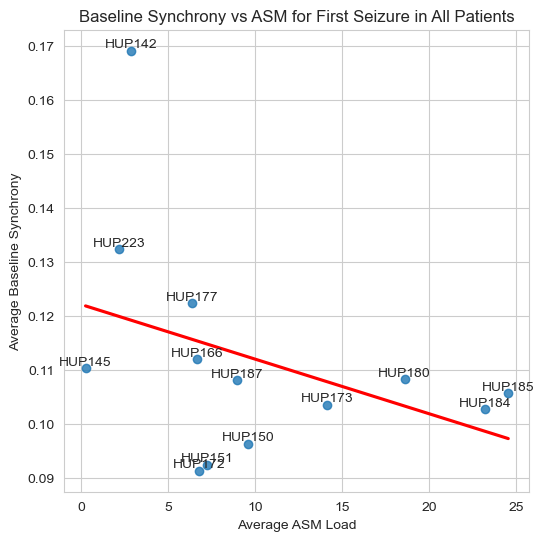

In [9]:
all_seizures_data = []

# Iterate through all patient data
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Get only the first seizure index
    first_seizure_idx = (
        hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].index[0]
        if not hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].empty
        else None
    )

    if first_seizure_idx:
        seizure_time = hourly_patient_features_df.loc[first_seizure_idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_ddd"])

        all_seizures_data.append((avg_med_load, avg_synchrony))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

for i, (x, y) in enumerate(zip(avg_med_loads_list, avg_synchronies_list)):
    plt.text(x, y, f"HUP{completed_hup_ids[i]}", fontsize=10, ha="center", va="bottom")

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.title("Baseline Synchrony vs ASM for First Seizure in All Patients")
plt.grid(True)
plt.show()